In [12]:
#data analysis of the predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
import datetime
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [13]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [14]:
alldata_processed =\
    pd.read_csv("./data/processed/alldata_processed_with_dev_residual.csv" )
alldata_processed['videoid'] = alldata_processed['videoid'].apply(lambda x: int(x))
#alldata_processed['Event_Date'] = pd.to_datetime(alldata_processed['Event_Date'],format='%Y-%m-%d')
print(list(alldata_processed))

['Patient_ID', 'examid', 'side', 'HipFlex_IC', 'HipRot_mean', 'KneeFlex_meanStance', 'KneeFlex_maxExtension', 'dxmod', 'dxside', 'faq', 'gmfcs', 'age', 'height', 'mass', 'cadence', 'speed', 'steplen', 'leglen', 'bmi', 'speedNorm', 'steplenNorm', 'cadenceNorm', 'videoid', 'GDI', 'n_sides', 'SEMLS', 'dataset', 'const', 'age_truncated', 'predicted_mass', 'mass_interpolated', 'log_interpolated_mass', 'predicted_height', 'height_interpolated', 'mass_buckets', 'height_buckets', 'age_buckets', 'mass_interpolated2', 'age_truncated2', 'height_interpolated2', 'predicted_SEMLS', 'SEMLS_dev_residual']


In [15]:
def add_predictions(df,target_col):
    predictions = pd.read_csv("./data/predictions/cnn_%s_predictions_best_epoch.csv" % (target_col),dtype={'videoid':int})
    predictions = predictions[['videoid','%s_pred_corrected' % (target_col)]]
    df = df.merge(right=predictions,on=['videoid'],how='left')
    return df

In [21]:
df = alldata_processed.copy()
print(list(df))
#df = add_predictions(df,"SEMLS_dev_residual")
df = add_predictions(df,"GDI")

['Patient_ID', 'examid', 'side', 'HipFlex_IC', 'HipRot_mean', 'KneeFlex_meanStance', 'KneeFlex_maxExtension', 'dxmod', 'dxside', 'faq', 'gmfcs', 'age', 'height', 'mass', 'cadence', 'speed', 'steplen', 'leglen', 'bmi', 'speedNorm', 'steplenNorm', 'cadenceNorm', 'videoid', 'GDI', 'n_sides', 'SEMLS', 'dataset', 'const', 'age_truncated', 'predicted_mass', 'mass_interpolated', 'log_interpolated_mass', 'predicted_height', 'height_interpolated', 'mass_buckets', 'height_buckets', 'age_buckets', 'mass_interpolated2', 'age_truncated2', 'height_interpolated2', 'predicted_SEMLS', 'SEMLS_dev_residual']


In [17]:
df['Anteversion'].fillna(np.mean(df['Anteversion']),inplace=True)

KeyError: 'Anteversion'

In [19]:
print(list(df))

['Patient_ID', 'examid', 'side', 'HipFlex_IC', 'HipRot_mean', 'KneeFlex_meanStance', 'KneeFlex_maxExtension', 'dxmod', 'dxside', 'faq', 'gmfcs', 'age', 'height', 'mass', 'cadence', 'speed', 'steplen', 'leglen', 'bmi', 'speedNorm', 'steplenNorm', 'cadenceNorm', 'videoid', 'GDI', 'n_sides', 'SEMLS', 'dataset', 'const', 'age_truncated', 'predicted_mass', 'mass_interpolated', 'log_interpolated_mass', 'predicted_height', 'height_interpolated', 'mass_buckets', 'height_buckets', 'age_buckets', 'mass_interpolated2', 'age_truncated2', 'height_interpolated2', 'predicted_SEMLS', 'SEMLS_dev_residual', 'GDI_pred_corrected']


In [24]:
df['SEMLS_dev_residual_pred_corrected_buckets'] = np.clip(np.floor(df['SEMLS_dev_residual']/0.1)*0.1,-0.6,0.2)

['Patient_ID', 'examid', 'side', 'HipFlex_IC', 'HipRot_mean', 'KneeFlex_meanStance', 'KneeFlex_maxExtension', 'dxmod', 'dxside', 'faq', 'gmfcs', 'age', 'height', 'mass', 'cadence', 'speed', 'steplen', 'leglen', 'bmi', 'speedNorm', 'steplenNorm', 'cadenceNorm', 'videoid', 'GDI', 'n_sides', 'SEMLS', 'dataset', 'const', 'age_truncated', 'predicted_mass', 'mass_interpolated', 'log_interpolated_mass', 'predicted_height', 'height_interpolated', 'mass_buckets', 'height_buckets', 'age_buckets', 'mass_interpolated2', 'age_truncated2', 'height_interpolated2', 'predicted_SEMLS', 'SEMLS_dev_residual', 'GDI_pred_corrected', 'SEMLS_dev_residual_pred_corrected_buckets']


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'mean(SEMLS) vs CNN predicted SEMLS dev residual: test set')

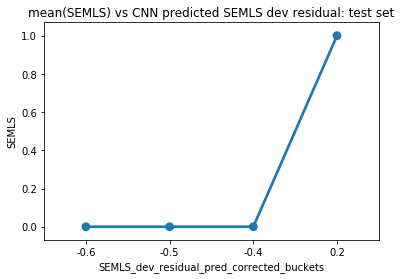

In [25]:
print(list(df[df['dataset'] == 'test']))
sns.pointplot(x='SEMLS_dev_residual_pred_corrected_buckets',y='SEMLS',data=df[df['dataset'] == 'test'])
plt.title("mean(SEMLS) vs CNN predicted SEMLS dev residual: test set")

In [27]:
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'SEMLS_dev_residual',#_pred_corrected',"isPostSurgGaitVisit",
         "const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS'] = lm.predict(X)

PerfectSeparationError: Perfect separation detected, results not available

In [ ]:
df['predicted_SEMLS_buckets'] =\
    np.clip(np.floor(df['predicted_SEMLS']/0.05)*0.05,0.05,0.4)

In [ ]:
print(roc_auc_score(df[df['dataset'] == 'train']['SEMLS'],
              df[df['dataset'] == 'train']['predicted_SEMLS']),"train ROC")

print(roc_auc_score(df[df['dataset'] == 'validation']['SEMLS'],
              df[df['dataset'] == 'validation']['predicted_SEMLS']),"validation ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS']),"test ROC")


In [ ]:
plt.scatter(df['SEMLS_dev_residual_pred_corrected'],df['GDI'])
plt.xlabel("Predicted SEMLS Dev Residual (Corrected)")
plt.ylabel("GDI")
plt.title("GDI vs. Predicted SEMLS Residual (entire dataset)");

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, thresholds = roc_curve(df[df['dataset'] == 'test']['SEMLS'],
          df[df['dataset'] == 'test']['predicted_SEMLS'])

In [ ]:
plt.plot(fpr,tpr)
plt.title("ROC Curve: Predicted SEMLS")
plt.xlabel("fpr")
plt.ylabel("tpr")

In [ ]:
#same analysis but using gdi instead of cnn predictions
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'GDI',"isPostSurgGaitVisit","const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS'] = lm.predict(X)
lm.summary2()

In [ ]:
print(roc_auc_score(df[df['dataset'] == 'train']['SEMLS'],
              df[df['dataset'] == 'train']['predicted_SEMLS']),"train ROC")

print(roc_auc_score(df[df['dataset'] == 'validation']['SEMLS'],
              df[df['dataset'] == 'validation']['predicted_SEMLS']),"validation ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS']),"test ROC")


In [ ]:
#including both variables
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2","SEMLS_dev_residual_pred_corrected",
         'GDI', "isPostSurgGaitVisit","const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS'] = lm.predict(X)
lm.summary2()

In [ ]:
print(roc_auc_score(df[df['dataset'] == 'train']['SEMLS'],
              df[df['dataset'] == 'train']['predicted_SEMLS']),"train ROC")

print(roc_auc_score(df[df['dataset'] == 'validation']['SEMLS'],
              df[df['dataset'] == 'validation']['predicted_SEMLS']),"validation ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS']),"test ROC")


Run the linear model on just the test dataset to get confidence intervals.

I use cluster robust standard errors clustered by the videoid (since for each video there is GDI_L, GDI_R and there's likely some within video correlation)

In [ ]:
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'GDI', "isPostSurgGaitVisit","SEMLS_dev_residual_pred_corrected","const"]

X_train = df[df['dataset'] == 'test'][Xcols]
y_train = df[df['dataset'] == 'test']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit(cov_type='cluster',cov_kwds={'groups':df[df['dataset'] == 'test']['videoid']})
lm.summary2()

# Analyze GDI Predictions

In [ ]:
alldata_subset = alldata_processed[['videoid','side','Event_Date','Patient_ID','GDI','gmfcs']].copy()
cnn_gdi_predictions = pd.read_csv("./data/predictions/cnn_GDI_predictions_best_epoch.csv",dtype={'videoid':str})
cnn_gdi_predictions['videoid'] = cnn_gdi_predictions['videoid'].apply(lambda x: int(x))
cnn_gdi_predictions = cnn_gdi_predictions.merge(right=alldata_subset,on=['videoid','side'],how='left')

In [ ]:
sns.reset_defaults();

In [ ]:
cnn_gdi_predictions[cnn_gdi_predictions['dataset'] == 'test'].corr()

In [ ]:
plt.scatter(cnn_gdi_predictions[cnn_gdi_predictions['dataset'] == 'test']['GDI_pred_corrected'],
            cnn_gdi_predictions[cnn_gdi_predictions['dataset'] == 'test']['GDI'])
plt.xlabel("Predicted GDI")
plt.ylabel("GDI")
plt.title("GDI Predictions: Test Set ($\\rho$ = 0.73)")
plt.savefig("./figures/gdi_scatterplot.png",dpi=600)

In [ ]:
#distribution of GDI in different GMFCS groups
sns.pointplot(x='gmfcs',y='GDI',data=cnn_gdi_predictions,color='green',
             label='GDI')
plt.ylabel("Average GDI")
plt.ylim([40,110]);
plt.title("GDI by GMFCS")
plt.legend()
plt.savefig("./figures/gmfcs_scatterplot.png",dpi=600)

In [ ]:
analyze_changes = cnn_gdi_predictions.sort_values(by=["Patient_ID","side","Event_Date"]).copy()
analyze_changes = analyze_changes[analyze_changes['dataset'] == 'test'].groupby(["Patient_ID","side"])["GDI","GDI_pred_corrected"].diff(1)

In [ ]:
forplot = analyze_changes.copy()
corr = forplot.corr()['GDI_pred_corrected']['GDI']
plt.scatter(forplot['GDI_pred_corrected'],forplot['GDI'])
plt.xlabel("Change in Predicted GDI")
plt.ylabel("Change in GDI")
plt.title("Change in Predicted GDI vs Change in GDI: Test Set (corr = %s)" % (corr))

In [ ]:
#showing increase in correlation for changes >= ~RMSE
forplot = analyze_changes[np.abs(analyze_changes['GDI_pred_corrected']) >= 8].copy()
corr = forplot.corr()['GDI_pred_corrected']['GDI']
plt.scatter(forplot['GDI_pred_corrected'],forplot['GDI'])
plt.xlabel("Change in Predicted GDI")
plt.ylabel("Change in GDI")
plt.title("Change in Predicted GDI vs Change in GDI: Test Set (corr = %s)" % (corr))